In [8]:
import pandas as pd
import numpy as np
from IPython.display import display, Image, HTML, Markdown
import pandas as pd
import json
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow import keras
import joblib


### LOAD AND PREPARE DATASET

In [9]:
dataset_path = 'ds_challenge_data_2022.csv'
with open(dataset_path, 'rb') as file:
    df = pd.read_csv(dataset_path, encoding='utf-16')


In [10]:
def extract_field_from_json(json_string, field):
    try:
        json_data = json.loads(json_string.replace("'", '"'))
        return json_data.get(field, None)
    except json.JSONDecodeError:
        return None


# Extract device brand -> dispositivo_marca
df['dispositivo_marca'] = df['dispositivo'].apply(lambda x: extract_field_from_json(x, 'marca'))

# Create an id for the user device
df['dispositivo_id'] = df['dispositivo'].apply(lambda x: extract_field_from_json(x, 'año')).astype(str)
df['dispositivo_id'] += df['dispositivo_marca']

# Extract isp -> dispositivo_proveedor
df['dispositivo_proveedor'] = df['dispositivo'].apply(lambda x: extract_field_from_json(x, 'proveedor'))


In [11]:
def get_commulative_features(user_df):
  # n_user_transactions
  user_df['n_user_transactions'] = np.arange(user_df.shape[0])


  # n_dispositivos_acumulados
  values = []
  for index, row in user_df.iterrows():
      values.append(len(user_df.loc[:index, 'dispositivo_id'].unique()))
  user_df['n_dispositivos_acumulados'] = values

  # has_previous_fraud
  values = []
  for index, row in user_df.iterrows():
      values.append(user_df.loc[:index, 'fraude'].max())
  user_df['has_previous_fraud'] = values


  # device used_before
  values = []
  for index, row in user_df.iterrows():
      values.append((user_df.loc[:index, 'dispositivo_id'] == user_df.loc[index, 'dispositivo_id']).sum() -1)

  user_df['device_used_before'] = values
  user_df['device_used_before'] = user_df['device_used_before'].astype(bool)

  return(user_df)




In [12]:
df_features = df.groupby('user_id').apply(get_commulative_features)

<ipython-input-12-a5ab097d1d63>:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_features = df.groupby('user_id').apply(get_commulative_features)


In [24]:
df_features.head()

,transaction_id,user_id,género,linea_tc,interes_tc,monto,fecha,hora,dispositivo,establecimiento,...,dcto,cashback,fraude,dispositivo_marca,dispositivo_id,dispositivo_proveedor,n_user_transactions,n_dispositivos_acumulados,has_previous_fraud,device_used_before
0,1,573,M,87000,56,581.03,02/01/20,0,"{'año': 2019, 'marca': 'Apple', 'proveedor': '...",Farmacia,...,0.0,17.43,False,Apple,2019Apple,Telcel,0,1,False,False
1,2,737,F,34000,51,421.73,02/01/20,0,"{'año': 2021, 'marca': 'Huawei', 'proveedor': ...",Tienda departamental,...,0.0,12.65,False,Huawei,2021Huawei,ATT,0,1,False,False
2,3,887,F,52000,38,399.55,02/01/20,0,"{'año': 2017, 'marca': 'Apple', 'proveedor': '...",Farmacia,...,0.0,11.99,False,Apple,2017Apple,ATT,0,1,False,False
3,4,1304,M,67000,60,828.01,02/01/20,0,"{'año': 2019, 'marca': 'Samsung', 'proveedor':...",Tienda departamental,...,0.0,24.84,False,Samsung,2019Samsung,ATT,0,1,False,False
4,5,1361,F,28000,52,886.04,02/01/20,0,"{'año': 2021, 'marca': 'Samsung', 'proveedor':...",Supermercado,...,0.0,26.58,False,Samsung,2021Samsung,Telcel,0,1,False,False


### Descriptive Analisis

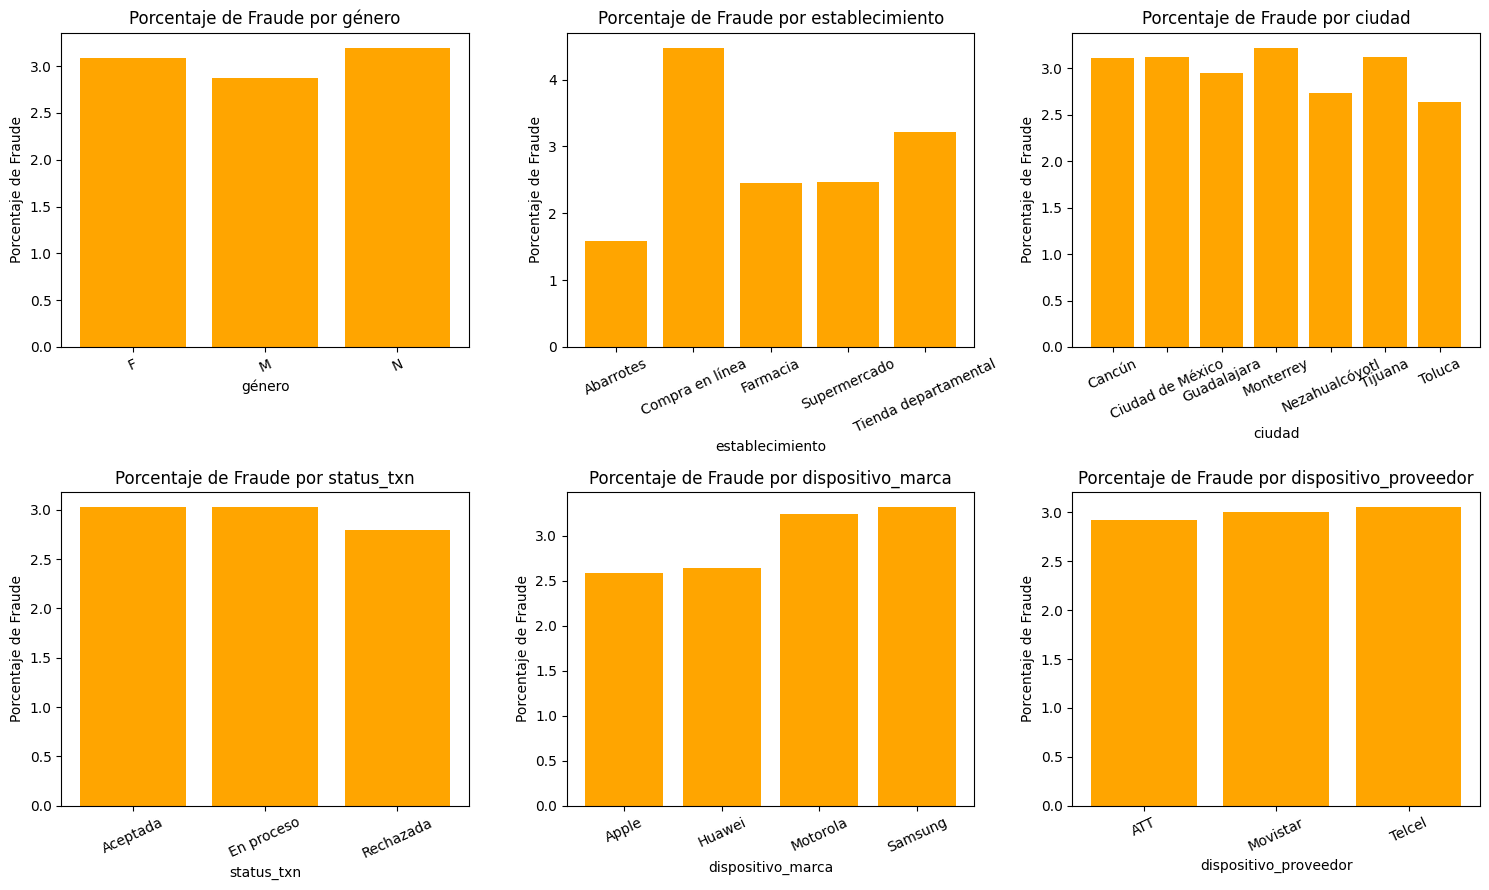

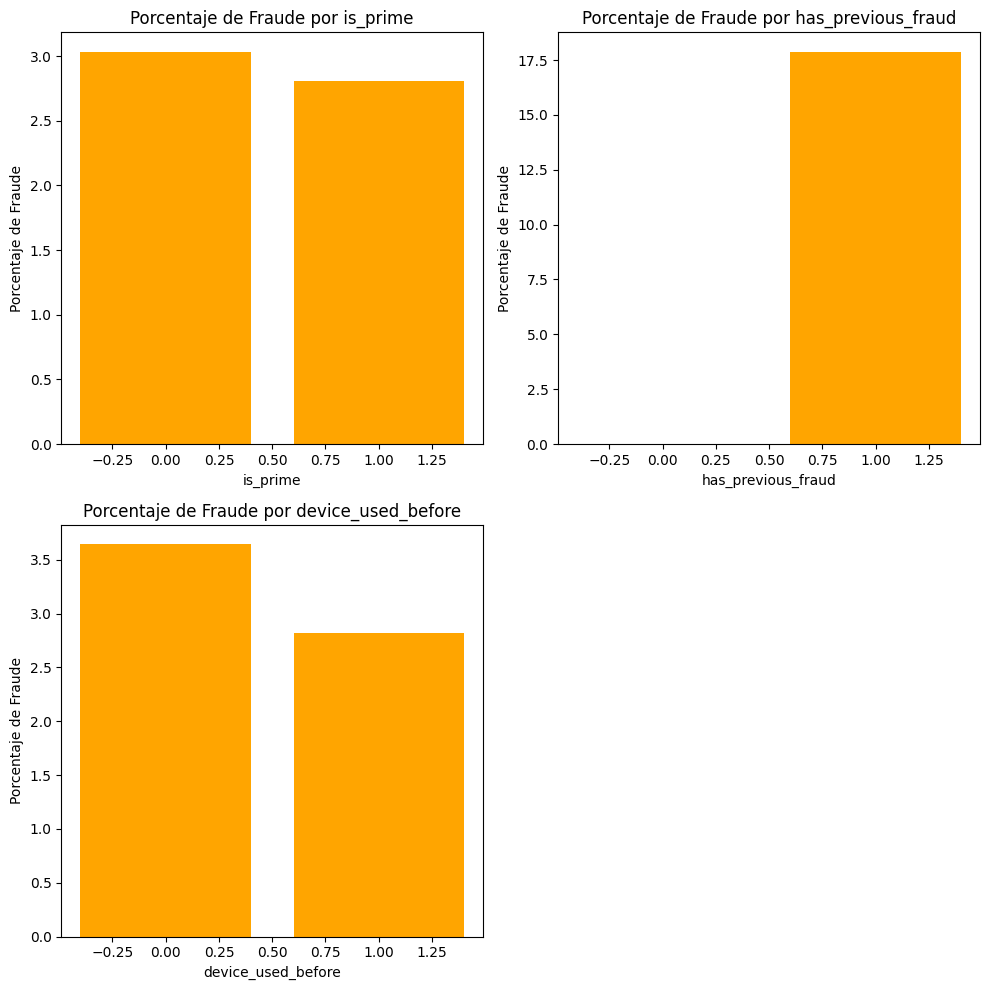

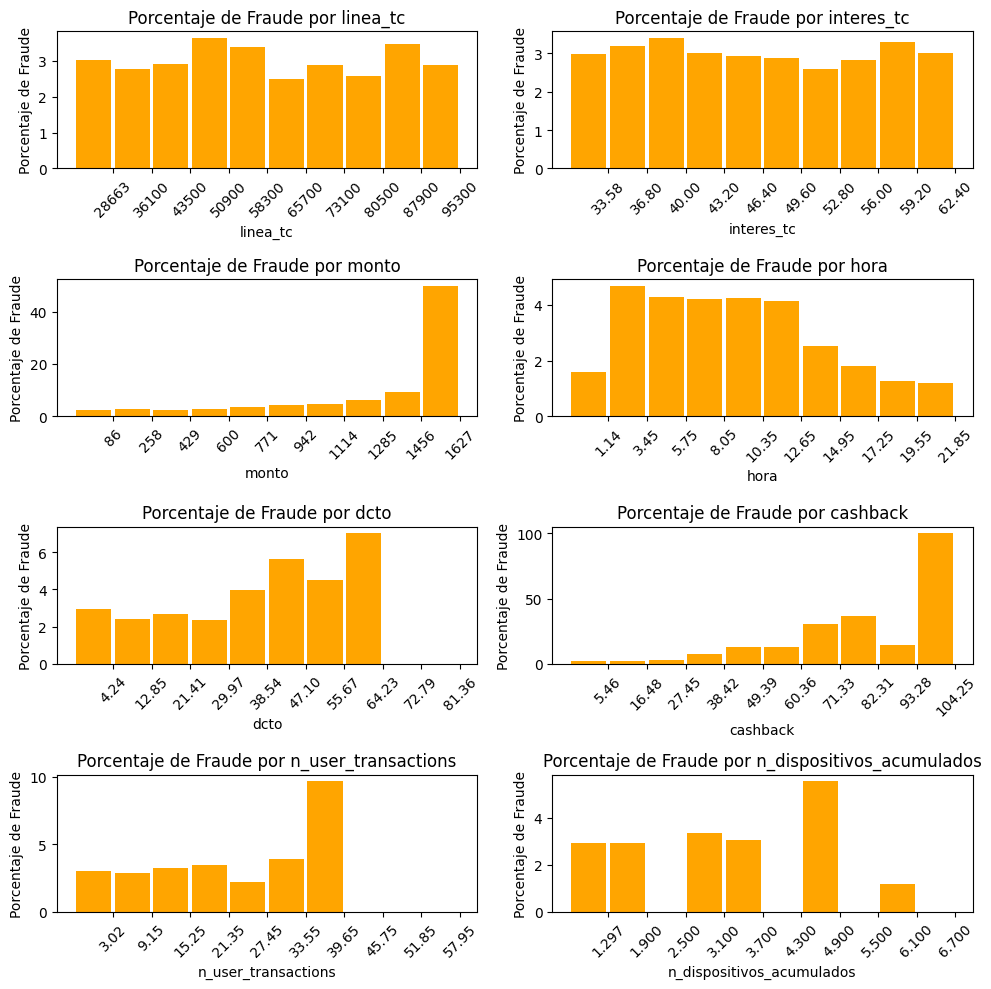

In [27]:
import matplotlib.pyplot as plt

categorical_variables = ['género', 'establecimiento', 'ciudad', 'status_txn', 'dispositivo_marca', 'dispositivo_proveedor']
binary_variables = ['is_prime', 'has_previous_fraud', 'device_used_before', 'fraude']
numerical_variables = ['linea_tc', 'interes_tc', 'monto', 'hora', 'dcto', 'cashback', 'n_user_transactions', 'n_dispositivos_acumulados']

# Create a matrix of subplots for categorical variables
num_cols = 3  # Number of columns in the matrix
num_rows = (len(categorical_variables) + 1) // num_cols  # Number of rows in the matrix
plt.figure(figsize=(15, 9))

for i, col in enumerate(categorical_variables):
    plt.subplot(num_rows, num_cols, i + 1)
    df_grouped = df_features.groupby([col])['fraude'].mean().reset_index()
    plt.bar(df_grouped[col], df_grouped['fraude'] * 100,color='orange')
    plt.xlabel(col)
    plt.ylabel('Porcentaje de Fraude')
    plt.title(f'Porcentaje de Fraude por {col}')
    plt.xticks(rotation=25)

plt.tight_layout()
plt.show()

# Create a matrix of subplots for binary variables
num_cols = 2  # Number of columns in the matrix

binary_variables
num_rows = (len(binary_variables[:-1]) + 1) // 2  # Number of rows in the matrix
plt.figure(figsize=(10, 10))

for i, col in enumerate(binary_variables[:-1]):
    plt.subplot(num_rows, num_cols, i + 1)
    df_grouped = df_features.groupby([col])['fraude'].mean().reset_index()
    plt.bar(df_grouped[col], df_grouped['fraude'] * 100,color='orange')
    plt.xlabel(col)
    plt.ylabel('Porcentaje de Fraude')
    plt.title(f'Porcentaje de Fraude por {col}')

plt.tight_layout()
plt.show()



# Create a matrix of subplots for numerical variables
num_cols = 2  # Number of columns in the matrix
num_rows = (len(numerical_variables) + 1) // 2  # Number of rows in the matrix
plt.figure(figsize=(10, 10))

for i, col in enumerate(numerical_variables):
    if col != 'fraude':
        plt.subplot(num_rows, num_cols, i + 1)
        df_grouped = df_features.groupby(pd.cut(df_features[col], bins=10))[['fraude']].mean().reset_index()
        plt.bar(
            df_grouped[col].apply(lambda interval: interval.left),
            df_grouped['fraude'] * 100,
            width=df_grouped.loc[0, col].length * 0.9,
            color='orange'
        )
        plt.xlabel(col)
        plt.ylabel('Porcentaje de Fraude')
        plt.title(f'Porcentaje de Fraude por {col}')
        plt.xticks(df_grouped[col].apply(lambda interval: interval.mid), rotation=45)

plt.tight_layout()
plt.show()



In [28]:
df_features.corr()

<ipython-input-28-b52e6d9f184c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_features.corr()


,transaction_id,user_id,linea_tc,interes_tc,monto,hora,is_prime,dcto,cashback,fraude,n_user_transactions,n_dispositivos_acumulados,has_previous_fraud,device_used_before
transaction_id,1.000000,-0.001544,-0.007086,-0.005885,0.004061,0.040174,0.002224,-0.008698,-0.000577,-0.000810,0.534915,0.221085,0.195089,0.433522
user_id,-0.001544,1.000000,0.013348,0.012076,0.005524,-0.003535,-0.009403,0.010621,0.007104,-0.010986,0.019027,0.029858,-0.012336,0.004148
linea_tc,-0.007086,0.013348,1.000000,-0.039932,-0.008641,-0.000338,0.014715,-0.006660,-0.010802,-0.000488,0.000031,-0.012063,-0.002607,0.004275
interes_tc,-0.005885,0.012076,-0.039932,1.000000,0.008421,0.003771,-0.017794,-0.007601,0.011794,-0.003130,0.021795,-0.005402,0.005343,0.005874
monto,0.004061,0.005524,-0.008641,0.008421,1.000000,-0.007814,-0.006740,0.238843,0.877533,0.039489,0.007977,0.008838,0.031143,0.015038
hora,0.040174,-0.003535,-0.000338,0.003771,-0.007814,1.000000,0.000464,0.011161,-0.011527,-0.048133,0.009690,0.000615,-0.033482,0.020786
is_prime,0.002224,-0.009403,0.014715,-0.017794,-0.006740,0.000464,1.000000,0.003887,-0.010398,-0.004409,-0.025681,-0.033965,-0.014962,-0.000531
dcto,-0.008698,0.010621,-0.006660,-0.007601,0.238843,0.011161,0.003887,1.000000,0.208479,0.014472,-0.004139,-0.001371,0.006574,0.005921
cashback,-0.000577,0.007104,-0.010802,0.011794,0.877533,-0.011527,-0.010398,0.208479,1.000000,0.106980,0.002424,0.006592,0.051575,0.011501
fraude,-0.000810,-0.010986,-0.000488,-0.003130,0.039489,-0.048133,-0.004409,0.014472,0.106980,1.000000,0.003500,0.010076,0.391489,-0.019798


In [ ]:
random_seed = 42


### Prepare Data for Modeling

In [ ]:
# Train / Test split (use new transactions as test)
train_test_split = .8
df_train = df_features[:int(df_features.shape[0] * train_test_split)]
df_test = df_features[int(df_features.shape[0] * train_test_split):]


# Columns for training
categorical_columns = ['género', 'establecimiento', 'ciudad', 'status_txn', 'dispositivo_marca', 'dispositivo_proveedor']
binary_columns = ['is_prime', 'has_previous_fraud', 'device_used_before']
numerical_columns = ['linea_tc', 'interes_tc', 'monto', 'hora', 'dcto', 'cashback', 'n_user_transactions', 'n_dispositivos_acumulados']

all_columns = categorical_columns+binary_columns+numerical_columns+['fraude']
df_train = df_train[all_columns]
df_test = df_test[all_columns]

In [ ]:
model_save_dir = "saved_models/"

In [ ]:
# One-Hot Encoding for categorical variables
df_train_encoded = pd.get_dummies(df_train, columns=categorical_columns)
df_test_encoded = pd.get_dummies(df_test, columns=categorical_columns)

# Ensure that df_train_encoded and df_test_encoded have the same columns
common_columns = set(df_train_encoded.columns) & set(df_test_encoded.columns)
missing_columns_train = set(df_test_encoded.columns) - set(df_train_encoded.columns)
missing_columns_test = set(df_train_encoded.columns) - set(df_test_encoded.columns)

# Add missing columns with all zeros
for col in missing_columns_train:
    df_train_encoded[col] = 0

for col in missing_columns_test:
    df_test_encoded[col] = 0




# Normalization of numerical variables
scaler = StandardScaler()
df_train_encoded[numerical_columns] = scaler.fit_transform(df_train_encoded[numerical_columns])
df_test_encoded[numerical_columns] = scaler.transform(df_test_encoded[numerical_columns])
scaler_filename = f"{model_save_dir}scaler.pkl"
joblib.dump(scaler, scaler_filename)

# Convert binary variables to numeric
df_train_encoded[binary_columns] = df_train_encoded[binary_columns].astype(int)
df_test_encoded[binary_columns] = df_test_encoded[binary_columns].astype(int)


# Apply oversampling to address class imbalance
oversampler = RandomOverSampler(sampling_strategy='minority', random_state=random_seed)
X_train_resampled, y_train_resampled = oversampler.fit_resample(df_train_encoded.drop('fraude', axis=1), df_train_encoded['fraude'])


In [ ]:


# Train and evaluate multiple models
models = {
    "Random Forest": RandomForestClassifier(random_state=random_seed),
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_seed),
    "AdaBoost": AdaBoostClassifier(random_state=random_seed),
    "SVM": SVC(random_state=random_seed),
    "Neural Network": MLPClassifier(random_state=random_seed, max_iter=500)
}


for model_name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the test set
    y_pred = model.predict(df_test_encoded.drop('fraude', axis=1))

    # Evaluate the model on df_test
    accuracy = accuracy_score(df_test_encoded['fraude'], y_pred)
    precision = precision_score(df_test_encoded['fraude'], y_pred)
    recall = recall_score(df_test_encoded['fraude'], y_pred)
    f1 = f1_score(df_test_encoded['fraude'], y_pred)
    confusion = confusion_matrix(df_test_encoded['fraude'], y_pred)

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix:\n{confusion}\n")

    # Save the trained model to a file
    model_filename = f"{model_save_dir}{model_name}_model.pkl"
    joblib.dump(model, model_filename)


Model: Random Forest
Accuracy: 0.9720111214087118
Precision: 0.5517241379310345
Recall: 0.1038961038961039
F1 Score: 0.17486338797814208
Confusion Matrix:
[[5228   13]
 [ 138   16]]

Model: Gradient Boosting
Accuracy: 0.8415199258572753
Precision: 0.1322140608604407
Recall: 0.8181818181818182
F1 Score: 0.22764227642276422
Confusion Matrix:
[[4414  827]
 [  28  126]]

Model: AdaBoost
Accuracy: 0.8222428174235403
Precision: 0.1297148114075437
Recall: 0.9155844155844156
F1 Score: 0.2272360999194198
Confusion Matrix:
[[4295  946]
 [  13  141]]

Model: SVM
Accuracy: 0.9345690454124189
Precision: 0.21971830985915494
Recall: 0.5064935064935064
F1 Score: 0.30648330058939094
Confusion Matrix:
[[4964  277]
 [  76   78]]

Model: Neural Network
Accuracy: 0.956997219647822
Precision: 0.27058823529411763
Recall: 0.2987012987012987
F1 Score: 0.28395061728395066
Confusion Matrix:
[[5117  124]
 [ 108   46]]



In [ ]:
import json

# Create a dictionary to store encoding information
encoding_info = {
    'categorical_columns': categorical_columns,
    'encoded_columns': list(df_train_encoded.columns)
}

# Save the encoding information to a JSON file
with open('encoding_info.json', 'w') as file:
    json.dump(encoding_info, file)
